In [1]:
import geopandas as gpd
import json

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
# from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import ticker
from matplotlib import patheffects
import numpy as np

In [2]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    # ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='white', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', color='white', fontsize=16)

In [3]:
## Access json matching bursts to frame IDs
import requests
from io import BytesIO
import zipfile

# URL of the ZIP file containing the JSON file
repo_zip_url = 'https://github.com/opera-adt/burst_db/releases/download/v0.3.1/burst-id-geometries-simple-0.3.1.geojson.zip'

# Download the ZIP file
response = requests.get(repo_zip_url)
zip_data = BytesIO(response.content)

# Extract the JSON file from the ZIP archive
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    # Assuming your JSON file is named 'data.json' within the ZIP
    json_data = zip_ref.read('burst-id-geometries-simple-0.3.1.geojson')

# Load the JSON data
data = json.loads(json_data.decode('utf-8')) # ['features']
gdf = gpd.GeoDataFrame.from_features(data)

In [4]:
gdf.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


In [5]:
# list of burst IDs used for training
burst_IDs = ['T050_105604_IW1','T050_105604_IW2','T050_105605_IW1','T050_105605_IW2','T050_105606_IW1',
             'T050_105606_IW2','T050_105607_IW1','T050_105607_IW2','T050_105608_IW1','T050_105608_IW2',
             'T050_105609_IW2','T050_105610_IW1','T050_105610_IW2','T050_105611_IW1','T050_105611_IW2',
             'T050_105612_IW1','T065_137822_IW1','T065_137823_IW1','T065_137823_IW2','T065_137824_IW1',
             'T065_137824_IW2','T065_137825_IW1','T065_137827_IW2','T065_137829_IW3','T065_137830_IW3',
             'T065_137831_IW3','T116_247720_IW1','T116_247721_IW1','T116_247722_IW1','T116_247723_IW1',
             'T116_247723_IW2','T116_247723_IW3','T116_247724_IW1','T116_247724_IW2','T116_247724_IW3',
             'T116_247725_IW1','T116_247725_IW2','T116_247725_IW3','T116_247726_IW1','T116_247726_IW2',
             'T116_247726_IW3','T116_247727_IW1','T116_247727_IW2','T116_247727_IW3','T116_247728_IW1',
             'T116_247729_IW1','T123_262402_IW2','T123_262402_IW3','T123_262403_IW2','T123_262403_IW3',
             'T123_262404_IW3','T123_262406_IW3','T123_262407_IW1','T123_262407_IW3','T123_262408_IW1',
             'T123_262408_IW2','T123_262409_IW1','T123_262412_IW2','T123_262415_IW1','T123_262416_IW1',
             'T145_310022_IW2','T145_310023_IW2','T145_310024_IW2','T145_310025_IW1','T145_310026_IW1',
             'T145_310027_IW1','T160_342226_IW2','T160_342229_IW1','T160_342229_IW2','T160_342230_IW1',
             'T160_342230_IW2','T160_342230_IW3','T160_342231_IW3']

In [6]:
burst_IDs = [x.lower() for x in burst_IDs]
gdf = gdf[gdf['burst_id_jpl'].isin(burst_IDs)].reset_index(drop=True)
gdf = gdf.set_crs('epsg:4326')

In [7]:
gdf.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((-140.96336 59.60396, -139.45432 59.7...",t050_105604_iw1,1,True,ASCENDING
1,"POLYGON ((-139.52878 59.82107, -137.93252 59.9...",t050_105604_iw2,1,True,ASCENDING
2,"POLYGON ((-141.03620 59.76761, -139.51971 59.9...",t050_105605_iw1,1,True,ASCENDING
3,"POLYGON ((-139.58911 59.98564, -137.98547 60.1...",t050_105605_iw2,1,True,ASCENDING
4,"POLYGON ((-141.10255 59.93199, -139.57949 60.0...",t050_105606_iw1,1,True,ASCENDING


### *Plotting the coverage of CSLC-S1s*

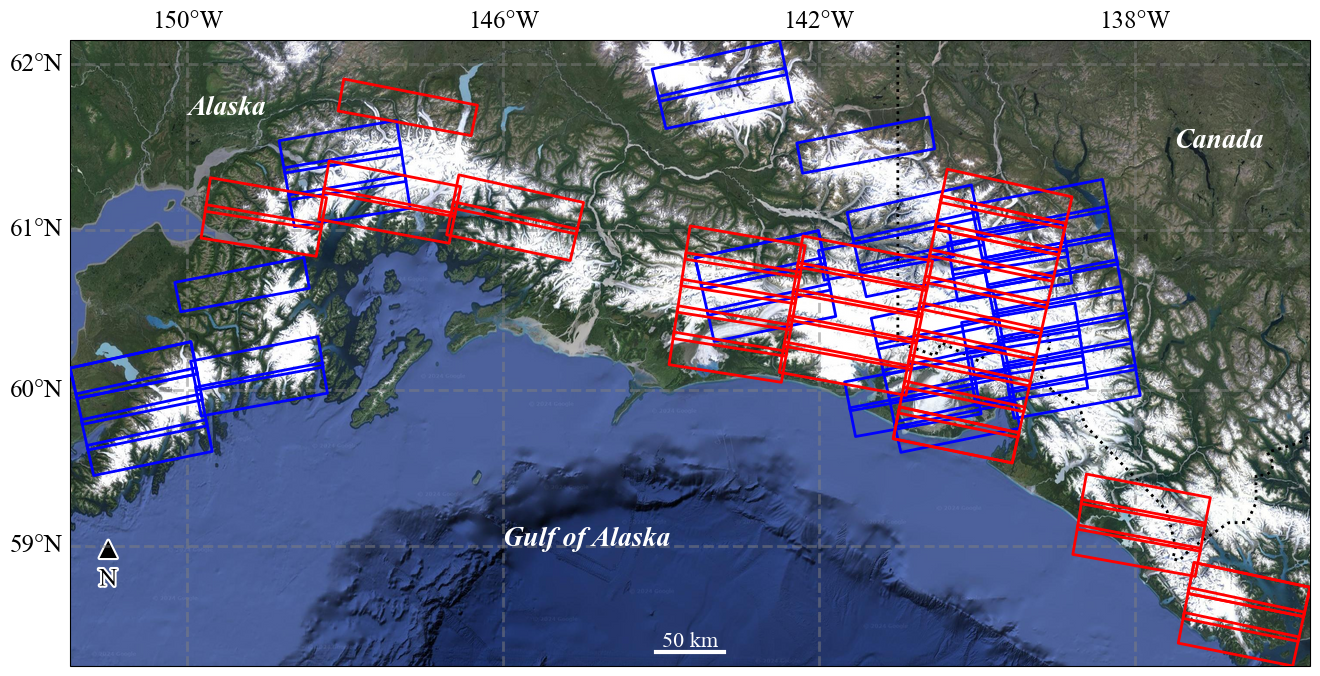

In [8]:
background = cimgt.GoogleTiles(style='satellite')

bounds = gdf.total_bounds

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(projection=background.crs)

ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])

zoomlevel = 8
ax.add_image(background, zoomlevel, interpolation='spline36')

ax.add_feature(cfeature.BORDERS.with_scale('50m'),linestyle=':',linewidth=2)

#addding scale bar
scale_bar(ax, 50, location=(0.5, 0.02))

#adding north arrow
buffer = [patheffects.withStroke(linewidth=3, foreground="w")]

ax.text(-151, 58.7, u'\u25B2\nN', transform=ccrs.PlateCarree(),   
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)

ax.text(-137.5, 61.5, 'Canada', transform=ccrs.PlateCarree(),color='white',style='italic',fontsize=20, weight='bold')
ax.text(-150, 61.7, 'Alaska', transform=ccrs.PlateCarree(),color='white',style='italic',fontsize=20, weight='bold')
ax.text(-146, 59, 'Gulf of Alaska', transform=ccrs.PlateCarree(),color='white',style='italic',fontsize=20, weight='bold')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels  = False
gl.right_labels = False
gl.xlocator = ticker.FixedLocator(range(-150,-135,4))
gl.ylocator = ticker.FixedLocator(range(59,73,1))

ax.add_geometries(gdf[gdf['orbit_pass']=='ASCENDING'].geometry, crs=ccrs.PlateCarree(), zorder=5, edgecolor='blue', facecolor='none', linewidth=2)
ax.add_geometries(gdf[gdf['orbit_pass']=='DESCENDING'].geometry, crs=ccrs.PlateCarree(), zorder=5, edgecolor='red', facecolor='none', linewidth=2)

plt.savefig('proc_burstIDs.png',dpi=300,bbox_inches='tight')

In [9]:
print('number of bursts IDs from descending track: ', gdf[gdf['orbit_pass']=='DESCENDING']['burst_id_jpl'].count())
print('number of bursts IDs from ascending track: ', gdf[gdf['orbit_pass']=='ASCENDING']['burst_id_jpl'].count())

number of bursts IDs from descending track:  36
number of bursts IDs from ascending track:  43
